In [1]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import jenkspy as jp
import math
from sklearn.manifold import MDS

In [34]:
NUM_VARS = 6
NUM_SETS = 6
NUM_SECTORS = 5

var_stats = {"mean": np.repeat(0, NUM_VARS), "sd": np.repeat(0.5, NUM_VARS)}
set_stats = [
    0.5,
    0.25,
    0.15,
    0.1,
    0.1,
    0.1,
]  # from imdb dataset then rounded to next .05
# original data
# 0.46,
# 0.25,
# 0.16,
# 0.11,
# 0.1,
# 0.09,

var_names = list(map(lambda i: f"V{i}", range(NUM_VARS)))  # raw value
varz_names = list(
    map(lambda vn: f"{vn}_z", var_names)
)  # min-max normalized value (for glyph drawing, perhaps)
varb_names = list(
    map(lambda vn: f"{vn}_b", var_names)
)  # fisher-jenks bin (also for glyph drawing)

set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))


In [35]:
def mvnorm(means, sds, size=10, random_state=None):
    dist = sps.multivariate_normal(means, sds)
    return dist.rvs(size=size, random_state=random_state)


def uniform(loc=0, scale=1, size=10, random_state=None):
    dist = sps.uniform(loc=loc, scale=scale)
    return dist.rvs(size=size, random_state=random_state)


def rvs(means, sds, limits, size=10, random_state=None):
    """Returns samples of D truncated normal distributions with the provided means, SDs and limits.
    The distributions are assumed to be independent, hence each dimension is sampled individually.
    The provided limits are assumed to be in sample space (as opposed to standard deviations).
    Note that SD and limits are dependent, i.e., if the limits are too narrow, the SD of the resulting
    distribution will be smaller than what was asked for."""
    D = min(len(means), len(sds), len(limits))
    result = np.empty((size, D))
    for i in range(D):
        l = limits[i][0]
        r = limits[i][1]
        m = means[i]
        s = sds[i]
        a, b = (l - m) / s, (r - m) / s
        samples = sps.truncnorm.rvs(
            a, b, loc=m, scale=s, size=size, random_state=random_state
        )
        result[:, i] = samples
    return result

In [36]:
means = var_stats["mean"]
sds = var_stats["sd"]


def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


def get_scale_from_shift_dir(dir, margin=0):
    return 0.2-2*margin if dir != 0 else 1


def get_loc_from_shift_dir(dir, margin=0):
    match dir:
        case 0:
            return 0
        case 1:
            return 0
        case 2:
            return 0.2 + margin
        case 3:
            return 0.4 + margin
        case 4:
            return 0.6 + margin
        case 5:
            return 0.8 + margin


def value_fits_dir(value, dir):
    match dir:
        case 0:
            return True
        case 1:
            return value < 0.2
        case 2:
            return value >= 0.2 and value < 0.4
        case 3:
            return value >= 0.4 and value < 0.6
        case 4:
            return value >= 0.6 and value < 0.8
        case 5:
            return value >= 0.8


def make_dataset(
    cluster1_size=20,
    cluster2_size=5,
    # cluster2_shift_direction is a list of length NUM_VARS. a 0 indicates no shift, any number above means the desired sector in a star glyph
    cluster2_shift_direction=[],
    sector_margin=.02
):
    cluster_defining_vars = list(
        [(i, d) for i, d in enumerate(cluster2_shift_direction) if d != 0]
    )
    samples1 = np.transpose(
        np.array([uniform(size=cluster1_size) for i in range(NUM_VARS)])
    )
    samples2 = np.transpose(
        np.array(
            [
                uniform(
                    loc=get_loc_from_shift_dir(cluster2_shift_direction[i], sector_margin),
                    scale=get_scale_from_shift_dir(cluster2_shift_direction[i], sector_margin),
                    size=cluster2_size,
                )
                for i in range(NUM_VARS)
            ]
        )
    )

    # go through cluster 1 and make sure that no data point has the same characteristics that define cluster 2
    # otherwise there would be systematic errors in the study results (participants answer correctly but we count it as erroneous)
    for j in range(samples1.shape[0]):
        while all(
            [value_fits_dir(samples1[j, v], dir) for v, dir in cluster_defining_vars]
        ):
            for v, _ in cluster_defining_vars:
                samples1[j, v] = uniform(size=1)[0]

    samples = np.concatenate((samples1, samples2))

    data = {}
    for i in range(NUM_VARS):
        x = samples[:, i]
        xz = norm(x)
        data[f"V{i}"] = x
        data[f"V{i}_z"] = xz
        data[f"V{i}_b"] = np.digitize(x, [0, 0.2, 0.4, 0.6, 0.8])

    data["cluster"] = np.concatenate(
        (np.repeat(0, cluster1_size), np.repeat(1, cluster2_size))
    )
    df = pd.DataFrame(data=data)

    local_set_stats = [stat for stat in set_stats]
    random.shuffle(local_set_stats)
    for i in range(NUM_SETS):
        freq = local_set_stats[i]
        df[f"S{i}"] = sps.binom.rvs(1, freq, size=cluster1_size + cluster2_size)

    # now a bit of postprocessing regarding sets
    set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))
    # we want all sets to have at least one element in each cluster
    # which at the same time ensures that no set has a single or no element
    genre_colsums = df[set_names + ["cluster"]].groupby("cluster").sum()
    for cluster in range(2):
        for genre in set_names:
            count = genre_colsums.loc[cluster, genre]
            if count == 0:
                # take random row of that cluster and add the set there
                randrow_start = 0 if cluster == 0 else cluster1_size
                randrow_end = (
                    cluster1_size if cluster == 0 else cluster1_size + cluster2_size
                )
                randrow = np.random.choice(
                    range(randrow_start, randrow_end), 1, replace=False
                )
                df.loc[randrow[0], genre] = 1
    # do the same sort of thing row-wise
    # there could be movies not in any set/genre, and we don't want that
    for i in range(df.shape[0]):
        while df.loc[i][set_names].sum() < 1:
            for j, genre in enumerate(set_names):
                # do the drawing again
                freq = local_set_stats[j]
                flag = sps.binom.rvs(1, freq, size=1)
                df.loc[i, genre] = flag

    return df


In [63]:
dataset = make_dataset(cluster2_shift_direction=[0, 1,1,5,5,0], cluster1_size=35,cluster2_size=5)
dataset


,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,...,V5,V5_z,V5_b,cluster,S0,S1,S2,S3,S4,S5
0,0.488314,0.497617,3,0.570815,0.582490,3,0.804684,0.819407,5,0.420119,...,0.655630,0.669854,4,0,0,0,0,1,0,0
1,0.391351,0.398728,2,0.378715,0.373144,2,0.885660,0.906943,5,0.385902,...,0.384622,0.387855,2,0,0,0,0,0,0,1
2,0.493303,0.502705,3,0.105192,0.075066,1,0.885206,0.906453,5,0.437056,...,0.025391,0.014054,1,0,0,0,0,0,1,1
3,0.579259,0.590368,3,0.916452,0.959155,5,0.510545,0.501440,3,0.278353,...,0.011884,0.000000,1,0,0,1,0,0,0,0
4,0.000389,0.000000,1,0.459500,0.461181,3,0.609079,0.607956,4,0.718579,...,0.972908,1.000000,5,0,0,0,0,0,0,1
5,0.366216,0.373094,2,0.807640,0.840574,5,0.050843,0.004497,1,0.247724,...,0.096347,0.087889,1,0,1,0,0,1,0,1
6,0.424368,0.432400,3,0.953932,1.000000,5,0.603582,0.602014,4,0.100234,...,0.464694,0.471174,3,0,0,0,0,1,0,0
7,0.980913,1.000000,5,0.594914,0.608752,3,0.416317,0.399578,3,0.458196,...,0.327823,0.328752,2,0,0,0,0,1,0,0
8,0.233977,0.238228,2,0.107406,0.077479,1,0.510025,0.500878,3,0.605266,...,0.636104,0.649536,4,0,0,0,0,1,0,0
9,0.146399,0.148911,1,0.366614,0.359956,2,0.409231,0.391919,3,0.463326,...,0.783896,0.803323,4,0,0,0,0,0,0,1


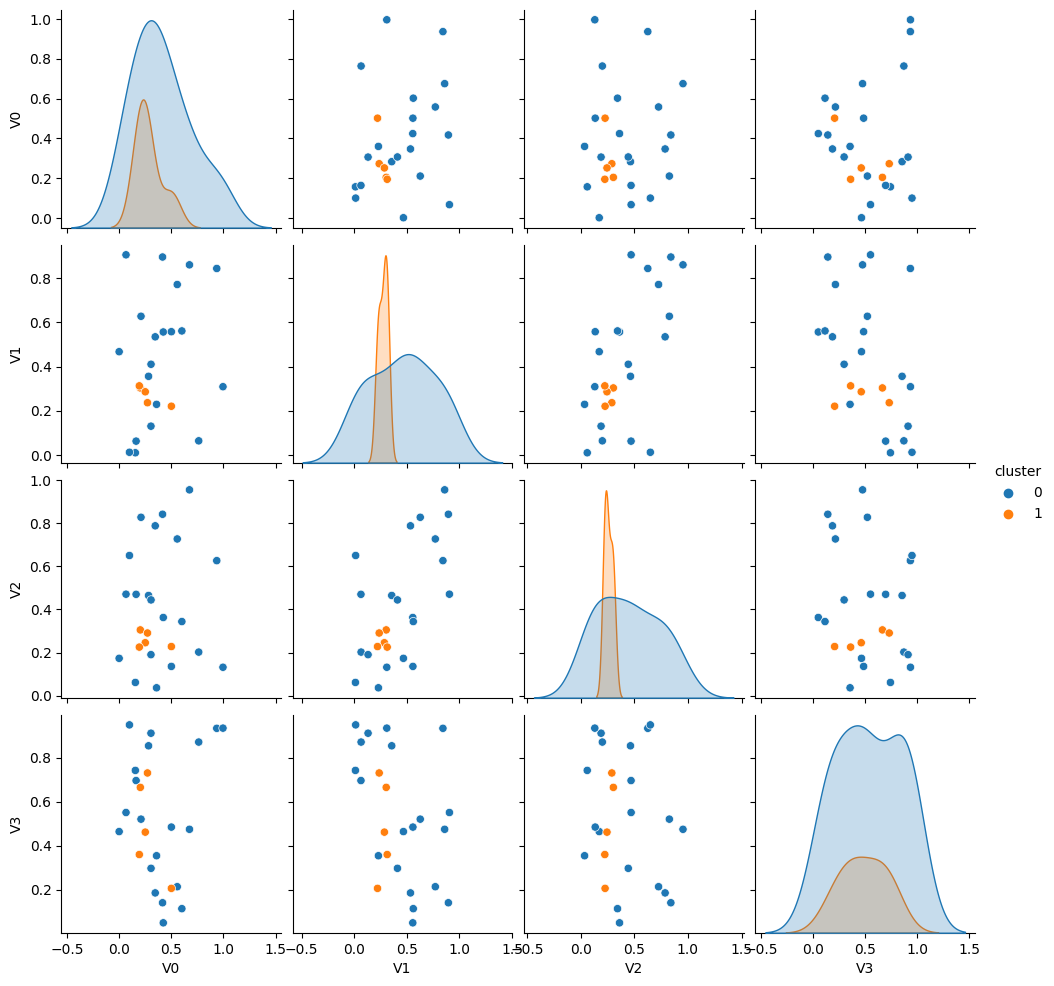

In [25]:
sns.pairplot(dataset[var_names + ["cluster"]], hue="cluster")

<Axes: xlabel='pca1', ylabel='pca2'>

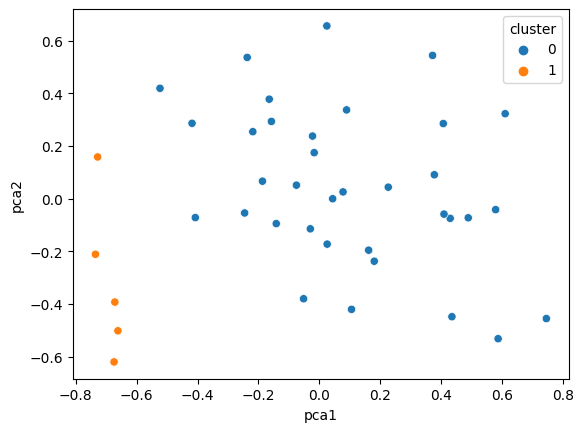

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
H_pca = pca.fit_transform(dataset[var_names])
sns.scatterplot(
    pd.DataFrame(
        data={
            "pca1": H_pca[:, 0],
            "pca2": H_pca[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="pca1",
    y="pca2",
    hue="cluster",
)

/Users/npiccolotto/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

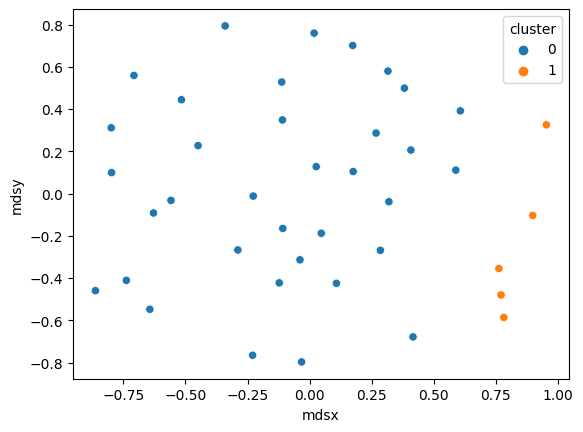

In [68]:
# quickly check the projection - we want the orange points bunched together
mds = MDS(n_components=2, metric=True, random_state=2, dissimilarity="euclidean")
# H_mds = mds.fit_transform(sps.zscore(dataset[varz_names]))
H_mds = mds.fit_transform(dataset[var_names])

sns.scatterplot(
    pd.DataFrame(
        data={
            "mdsx": H_mds[:, 0],
            "mdsy": H_mds[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="mdsx",
    y="mdsy",
    hue="cluster",
)

In [29]:
dataset


,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,V3_z,V3_b,cluster,S0,S1,S2,S3,S4,S5
0,0.881476,0.880313,5,0.473063,0.451438,3,0.672429,0.708403,4,0.496224,0.427055,3,0,0,1,0,1,1,0
1,0.964982,0.964765,5,0.705389,0.704165,4,0.190134,0.195251,1,0.554613,0.497159,3,0,0,1,0,1,0,0
2,0.887099,0.885999,5,0.058066,0.000000,1,0.804028,0.848422,5,0.592958,0.543197,3,0,0,1,0,0,0,0
3,0.394380,0.387699,2,0.940507,0.959930,5,0.359869,0.375846,2,0.708948,0.682459,4,0,0,1,0,0,0,0
4,0.152594,0.143176,1,0.680635,0.677238,4,0.006624,0.000000,1,0.957224,0.980547,5,0,0,1,0,0,0,0
5,0.348076,0.340871,2,0.263585,0.223566,2,0.670184,0.706015,4,0.767193,0.752390,4,0,0,0,0,1,0,0
6,0.947294,0.946877,5,0.481930,0.461085,3,0.146935,0.149288,1,0.815564,0.810465,5,0,1,0,0,0,1,1
7,0.978455,0.978390,5,0.713013,0.712459,4,0.586809,0.617304,3,0.812770,0.807111,5,0,0,0,0,1,0,0
8,0.912767,0.911958,5,0.382390,0.352804,2,0.041451,0.037055,1,0.690256,0.660016,4,0,0,0,1,0,0,0
9,0.120443,0.110660,1,0.834527,0.844643,5,0.092484,0.091353,1,0.973426,1.000000,5,0,1,1,0,1,0,0


In [31]:
import os.path as osp

dpi = 300


def make_glyphs(name, mdf, target_path = 'eval/dataset'):
    result = []
    for i in mdf.index:
        datacase = mdf.loc[i]
        angles = [n / float(NUM_VARS) * 2 * math.pi for n in range(NUM_VARS)] + [0]
        values = [datacase[varz_names[j]] for j in range(NUM_VARS)] + [
            datacase[varz_names[0]]
        ]

        ax = plt.subplot(111, polar=True)
        ax.figure.patch.set_alpha(0)
        ax.figure.set_size_inches(1, 1)
        ax.set_ylim(bottom=0, top=1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xticks(np.pi / 180.0 * np.linspace(180, -180, NUM_VARS, endpoint=False))
        ax.set_thetalim(-np.pi, np.pi)
        ax.spines[:].set_linewidth(0.5)

        ax.plot(angles, values, linewidth=0, linestyle="solid")
        ax.fill(angles, values, "k", alpha=1)

        plt.tick_params(
            grid_linestyle="dashed",
            grid_linewidth=0.5,
            left=False,
            right=False,
            bottom=False,
            top=False,
            labelleft=False,
            labelright=False,
            labelbottom=False,
            labeltop=False,
        )

        plt.tight_layout(pad=-1)
        filename = f"./img/{name}_{i}_thumb.png"
        plt.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=False)
        plt.clf()
        result.append(osp.join(target_path, filename))
    return result


In [32]:
import json
import scipy.spatial.distance as scidist
from itertools import combinations, pairwise, product

NUM_CLUSTER_DEFINING_VARS = 3
# Generate random datasets
# for i in range(27):
def make_complete_dataset(prefix, i, n=20, cluster1_size=15):

    ds_name = f"{prefix}_dataset{i}_{n}"
    print(ds_name)
    # ensure 2 adjacent vars to that the possible visual proxy (line slope in sector)
    # for reading the star chart is not better/worse for some instances
    cluster_defining_vars = random.sample(range(NUM_VARS), k=NUM_CLUSTER_DEFINING_VARS)
    not_cluster_defining_vars = [
        v for v in range(NUM_VARS) if v not in cluster_defining_vars
    ]
    cluster_defining_starglyph_sections = random.choices(
        range(1, NUM_SECTORS + 1), k=NUM_CLUSTER_DEFINING_VARS
    )
    cluster_definers = zip(cluster_defining_vars, cluster_defining_starglyph_sections)

    shift_direction = np.repeat(0, NUM_VARS)
    for v, d in cluster_definers:
        shift_direction[v] = d

    cluster1_margin = math.floor(0.125 * cluster1_size)
    cluster1_size = random.randint(cluster1_size-cluster1_margin, cluster1_size+cluster1_margin) # 15 plus minus 2
    cluster2_size = n - cluster1_size

    df = make_dataset(
        cluster1_size=cluster1_size,
        cluster2_size=cluster2_size,
        cluster2_shift_direction=shift_direction,
    )

    # determine every possible question that could be asked with this dataset
    # ie.: cluster-defining sets, non-cluster-defining sets, and same for variables
    cdef_sets = random.choice(
        [
            (s1, s2)
            for s1, s2 in combinations(set_names, 2)
            if len(df.query(f"{s1} == 1 & {s2} == 1")) >= 3
        ]
    )
    ncdef_sets = random.choice(
        [
            (s1, s2)
            for s1, s2 in combinations(set_names, 2)
            if (s1, s2) != cdef_sets and len(df.query(f"{s1} == 1 | {s2} == 1")) >= 3
        ]
    )
    cdef_vars = [
        (
            var_names[v],
            cluster_defining_starglyph_sections[cluster_defining_vars.index(v)],
        )
        for v in range(NUM_VARS)
        if v in cluster_defining_vars
    ]

    ncdef_vars_choices = []
    for length in range(2, NUM_VARS):
        for variables in combinations(range(NUM_VARS), length):
            for p in product(range(1, NUM_SECTORS + 1), repeat=length):
                ncdp = list(zip(variables, p))
                qs = " & ".join(map(lambda s: f"V{s[0]}_b == {s[1]}", ncdp))
                dfq = df.query(qs)
                if dfq.cluster.nunique() > 1 and len(df) >= 3:
                    ncdef_vars_choices.append(
                        list(map(lambda s: (var_names[s[0]], s[1]), ncdp))
                    )
    ncdef_vars = random.choice(ncdef_vars_choices)

    with open(f"{ds_name}_meta.json", "w") as f:
        json.dump(
            {
                "cdef_vars": cdef_vars,
                "ncdef_vars": ncdef_vars,
                "cdef_sets": cdef_sets,
                "ncdef_sets": ncdef_sets,
                "cluster_defining_vars": list(
                    map(lambda v: var_names[v], cluster_defining_vars)
                ),
                "cluster_defining_starglyph_sections": cluster_defining_starglyph_sections,
            },
            f,
        )

    df.to_csv(f"{ds_name}.csv", index=False)

    glyphs = make_glyphs(ds_name, df, target_path='designspace-test/')

    ds_dists = scidist.squareform(scidist.pdist(df[var_names], scidist.euclidean))
    set_dists = scidist.squareform(scidist.pdist(df[set_names], scidist.jaccard))

    sets_per_row = []
    for j in df.index:
        sets_per_row.append([g for g in set_names if df.loc[j, g] == 1])

    with open(f"{ds_name}.json", "w", encoding="utf8") as f:
        jsonstr = {
            "glyph_ids": glyphs,
            "E": list(
                map(lambda x: str(x), df.index.tolist())
            ),
            "EA": ds_dists.tolist(),
            "SR": sets_per_row,
            "S": set_names,
            "SA": set_dists.tolist(),
        }
        json.dump(jsonstr, f, ensure_ascii=False)

ds_dataset0_20
ds_dataset1_40
ds_dataset2_60
ds_dataset3_80
ds_dataset4_100


KeyboardInterrupt: 

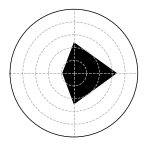

In [33]:
sizes = list([i*20 for i in range(1,11)])
c1_sizes = list(map(lambda s: round(.75*s),sizes))

for i,d in enumerate(zip(sizes,c1_sizes)):
    s,c1s = d
    make_complete_dataset('ds',i,s,c1s)